# Clustering by Bayesian technique
+ 2 Bayesian methods can cluster data:
    1. Sampling the latent variables from joint distribution of parameter and latent variables.
    2. Sampling the latetn variables from marginalized distribution over parameter.

## About method 1:
+ Procedure of method 1 is as follows:
    1. Decide initial state of latent variables
    2. Sampling parameter $w$ from the following distribution:
        + $p(w|y^n) = Dir(a|\{\hat{\alpha}_k\}_{k=1}^K) \prod_{k=1}^K \prod_{j=1}^M N(b_{kj}|\hat{\mu}_{kj}, (s_{kj} \hat{\beta}_{kj})^{-1} ) Gam(s_{kj}|\hat{\gamma}_{kj}, \hat{\delta}_{kj})$, where  
            + $\hat{\alpha}_k = \sum_{i=1}^n y_k^{(i)} + \alpha$,  
            + $\hat{\beta}_k = \sum_{i=1}^n y_k^{(i)} + \beta$,  
            + $\hat{\mu}_k = \frac{1}{\hat{\beta}_k} \sum_{i=1}^n y_k^{(i)} x^{(i)}$
            + $\hat{\gamma}_{kj} = \gamma_k + \frac{1}{2}\sum_{i=1}^n y_k^{(i)}$
            + $\hat{\delta}_{kj} = \delta_k + \frac{1}{2}\sum_{i=1}^n y_{k}^{(i)}(x_{j}^{(i)})^2 - \frac{\hat{\beta}_{kj}}{2}\hat{m}_{kj}^2$
    3. Sampling latent variables from the following distribution:
        + Let $L_{ik} = \log a_k + \frac{1}{2}\sum_{j=1}^M \log s_{kj} - \sum_{j=1}^M \frac{s_{kj}}{2} (x_j^{(i)} - b_{kj})^2$,
        + Then for each $i = 1,...,n$, $p(y_k^{(i)}=1|w) = \frac{\exp(L_{ik})}{\sum_{l=1}^K \exp(L_{il})}$.
    4. Back to 2.

## About method 2:

In [2]:
%matplotlib inline

In [3]:
from IPython.core.display import display, Markdown, Latex
import numpy as np
from scipy.special import gammaln, psi
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, cauchy, laplace, gumbel_r, norm, skewnorm
import math

In [4]:
def printmd(x):
    display(Markdown(x))

## Generate training data from true distribution

In [5]:
data_seed = 20190522
true_ratio = np.array([0.33, 0.33, 0.34])
true_delta = 0
true_s = np.array([[2, 2], [0.5, 0.5], [1, 1]])
true_b = np.array([[4, 4], [-4, -4], [0, 0]])
n = 2000
M = true_b.shape[1]
np.random.seed(data_seed)

In [6]:
true_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
true_label_arg = np.argmax(true_label, axis = 1)

In [7]:
# ### true distribution is GMM
# import math
# x = np.zeros((n, M))
# for i in range(n):
#     for j in range(M):
#         x[i, j] = norm.rvs(loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)
# noise_data_num = math.ceil(n*true_delta)
# if noise_data_num > 0:
#     x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

In [8]:
# ### ラプラス分布の混合の場合
# import math
# x = np.zeros((n, M))
# for i in range(n):
#     for j in range(M):
#         x[i, j] = laplace.rvs(loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)
# noise_data_num = math.ceil(n*true_delta)
# if noise_data_num > 0:
#     x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

In [9]:
# ### Mixture of Gumbel distribution
# np.random.seed(data_seed)
# x = np.zeros((n, M))
# for i in range(n):
#     for j in range(M):
#         x[i, j] = gumbel_r.rvs(loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

# noise_data_num = math.ceil(n*true_delta)
# if noise_data_num > 0:
#     x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

In [10]:
# ### Mixture of student distribution
# np.random.seed(data_seed)
# x = np.zeros((n, M))
# for i in range(n):
#     for j in range(M):
#         x[i, j] = t.rvs(df = 1.5, loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

# noise_data_num = math.ceil(n*true_delta)
# if noise_data_num > 0:
#     x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

In [11]:
### Mixture of normal-skew distribution
np.random.seed(data_seed)
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = skewnorm.rvs(a = 2, loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)

noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
    x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)

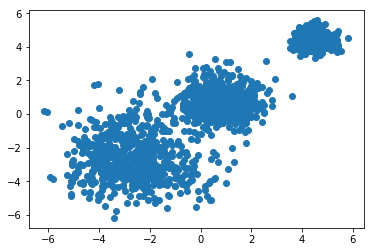

In [12]:
plt.scatter(x[:,0], x[:,1])
plt.show()

In [13]:
### learning setting
learning_seed = 20190529
burn_in = 20
sampling_interval = 5
sampling_num = 1000

K = 5
pri_alpha = 0.1
pri_beta = 0.01
pri_gamma = 2
pri_delta = 2


In [15]:
(post_a, post_s, post_b, post_latent_prob, post_latet_label) = bayesian_sampling_gibbs(x = x, sampling_num = sampling_num, K = K,                             
                                                                                       learning_seed = learning_seed, burn_in=burn_in, sampling_interval=sampling_interval,
                                                                                       pri_alpha=pri_alpha, pri_beta=pri_beta, pri_gamma=pri_gamma, pri_delta=pri_delta)

In [15]:
np.random.seed(learning_seed)

In [16]:
### Decide initial value
current_latent_label = np.random.multinomial(1, pvals = np.ones(K)/K, size=n)
current_latent_arg = np.argmax(current_latent_label, axis = 1)

In [14]:
def bayesian_sampling_gibbs(x:np.ndarray, sampling_num:int, K:int,
                            learning_seed:int=-1, burn_in:int=20, sampling_interval:int=5,
                            pri_alpha:float=0.1, pri_beta:float=0.01, pri_gamma=2, pri_delta=2) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Bayesian clustering based on gibbs sampling of joint posterior distribution of parameter and latent variables.
    
    """
    (n, M) = x.shape
    if learning_seed > 0:
        np.random.seed(learning_seed)
    ### Decide initial value
    current_latent_label = np.random.multinomial(1, pvals = np.ones(K)/K, size=n)
    current_latent_arg = np.argmax(current_latent_label, axis = 1)    
    expand_x = np.repeat(x, K).reshape(n,M,K).transpose(0,2,1)

    ### Calculate the steps until burn_in times
    for i_burnin in range(burn_in):
        ### Samnpling from parameters
        n_k = current_latent_label.sum(axis = 0)
        current_alpha = n_k + pri_alpha
        current_beta = n_k + pri_beta
        current_mu = current_latent_label.T @ x / (np.repeat(current_beta, M).reshape(K,M))
        current_gamma = n_k/2 + pri_gamma
        current_delta = current_latent_label.T @ x**2/2 - np.repeat(current_beta,M).reshape(K,M) * current_mu**2/2 + pri_delta

        current_s = np.random.gamma(shape=np.repeat(current_gamma, M).reshape(K,M), scale=1/current_delta)
        current_b = np.array([np.random.multivariate_normal(current_mu[k,:], np.diag(1/(current_s[k,:]*current_beta[k]))) for k in range(K)])
        current_a = np.random.dirichlet(current_alpha)

        ### Sampling from latent variables
        expand_s = np.repeat(current_s, n).reshape(K,M,n).transpose(2,0,1)
        expand_b = np.repeat(current_b, n).reshape(K,M,n).transpose(2,0,1)
        loglik = np.repeat(np.log(current_a) + np.log(current_s).sum(axis=1)/2, n).reshape(K,n).T - (expand_s * (expand_b - expand_x)**2/2).sum(axis = 2)
        max_loglik = loglik.max(axis = 1)
        norm_loglik = loglik - np.repeat(max_loglik,K).reshape(n,K)
        current_latent_prob = np.exp(norm_loglik) / np.repeat(np.exp(norm_loglik).sum(axis = 1), K).reshape(n,K)
        current_latent_label = np.array([np.random.multinomial(n=1, pvals = current_latent_prob[i,:], size = 1) for i in range(n)]).squeeze()

    ind = 0
    post_s = np.zeros((sampling_num,K,M))
    post_b = np.zeros((sampling_num,K,M))
    post_a = np.zeros((sampling_num,K))

    post_latent_prob = np.zeros((sampling_num,n,K))
    post_latent_label = np.zeros((sampling_num,n,K))
    for ite in range(sampling_interval * sampling_num):
        ### Samnpling from parameters
        n_k = current_latent_label.sum(axis = 0)
        current_alpha = n_k + pri_alpha
        current_beta = n_k + pri_beta
        current_mu = current_latent_label.T @ x / (np.repeat(current_beta, M).reshape(K,M))
        current_gamma = n_k/2 + pri_gamma
        current_delta = current_latent_label.T @ x**2/2 - np.repeat(current_beta,M).reshape(K,M) * current_mu**2/2 + pri_delta

        current_s = np.random.gamma(shape=np.repeat(current_gamma, M).reshape(K,M), scale=1/current_delta)
        current_b = np.array([np.random.multivariate_normal(current_mu[k,:], np.diag(1/(current_s[k,:]*current_beta[k]))) for k in range(K)])
        current_a = np.random.dirichlet(current_alpha)

        ### Sampling from latent variables
        expand_s = np.repeat(current_s, n).reshape(K,M,n).transpose(2,0,1)
        expand_b = np.repeat(current_b, n).reshape(K,M,n).transpose(2,0,1)
        loglik = np.repeat(np.log(current_a) + np.log(current_s).sum(axis=1)/2, n).reshape(K,n).T - (expand_s * (expand_b - expand_x)**2/2).sum(axis = 2)
        max_loglik = loglik.max(axis = 1)
        norm_loglik = loglik - np.repeat(max_loglik,K).reshape(n,K)
        current_latent_prob = np.exp(norm_loglik) / np.repeat(np.exp(norm_loglik).sum(axis = 1), K).reshape(n,K)
        current_latent_label = np.array([np.random.multinomial(n=1, pvals = current_latent_prob[i,:], size = 1) for i in range(n)]).squeeze()

        if ite % sampling_interval == 0:
            post_s[ind,:,:] = current_s
            post_b[ind,:,:] = current_b
            post_a[ind,:] = current_a
            post_latent_prob[ind,:,:] = current_latent_prob
            post_latent_label[ind,:,:] = current_latent_label
            ind += 1
        
    return(post_a, post_s, post_b, post_latent_prob, post_latent_label)

In [18]:
expand_x = np.repeat(x, K).reshape(n,M,K).transpose(0,2,1)

### Calculate the steps until burn_in times
for i_burnin in range(burn_in):
    ### Samnpling from parameters
    n_k = current_latent_label.sum(axis = 0)
    current_alpha = n_k + pri_alpha
    current_beta = n_k + pri_beta
    current_mu = current_latent_label.T @ x / (np.repeat(current_beta, M).reshape(K,M))
    current_gamma = n_k/2 + pri_gamma
    current_delta = current_latent_label.T @ x**2/2 - np.repeat(current_beta,M).reshape(K,M) * current_mu**2/2 + pri_delta

    current_s = np.random.gamma(shape=np.repeat(current_gamma, M).reshape(K,M), scale=1/current_delta)
    current_b = np.array([np.random.multivariate_normal(current_mu[k,:], np.diag(1/(current_s[k,:]*current_beta[k]))) for k in range(K)])
    current_a = np.random.dirichlet(current_alpha)

    ### Sampling from latent variables
    expand_s = np.repeat(current_s, n).reshape(K,M,n).transpose(2,0,1)
    expand_b = np.repeat(current_b, n).reshape(K,M,n).transpose(2,0,1)
    loglik = np.repeat(np.log(current_a) + np.log(current_s).sum(axis=1)/2, n).reshape(K,n).T - (expand_s * (expand_b - expand_x)**2/2).sum(axis = 2)
    max_loglik = loglik.max(axis = 1)
    norm_loglik = loglik - np.repeat(max_loglik,K).reshape(n,K)
    current_latent_prob = np.exp(norm_loglik) / np.repeat(np.exp(norm_loglik).sum(axis = 1), K).reshape(n,K)
    current_latent_label = np.array([np.random.multinomial(n=1, pvals = current_latent_prob[i,:], size = 1) for i in range(n)]).squeeze()

In [19]:
ind = 0
post_s = np.zeros((sampling_num,K,M))
post_b = np.zeros((sampling_num,K,M))
post_a = np.zeros((sampling_num,K))

post_latent_prob = np.zeros((sampling_num,n,K))
post_latent_label = np.zeros((sampling_num,n,K))
for ite in range(sampling_interval * sampling_num):
    ### Samnpling from parameters
    n_k = current_latent_label.sum(axis = 0)
    current_alpha = n_k + pri_alpha
    current_beta = n_k + pri_beta
    current_mu = current_latent_label.T @ x / (np.repeat(current_beta, M).reshape(K,M))
    current_gamma = n_k/2 + pri_gamma
    current_delta = current_latent_label.T @ x**2/2 - np.repeat(current_beta,M).reshape(K,M) * current_mu**2/2 + pri_delta

    current_s = np.random.gamma(shape=np.repeat(current_gamma, M).reshape(K,M), scale=1/current_delta)
    current_b = np.array([np.random.multivariate_normal(current_mu[k,:], np.diag(1/(current_s[k,:]*current_beta[k]))) for k in range(K)])
    current_a = np.random.dirichlet(current_alpha)

    ### Sampling from latent variables
    expand_s = np.repeat(current_s, n).reshape(K,M,n).transpose(2,0,1)
    expand_b = np.repeat(current_b, n).reshape(K,M,n).transpose(2,0,1)
    loglik = np.repeat(np.log(current_a) + np.log(current_s).sum(axis=1)/2, n).reshape(K,n).T - (expand_s * (expand_b - expand_x)**2/2).sum(axis = 2)
    max_loglik = loglik.max(axis = 1)
    norm_loglik = loglik - np.repeat(max_loglik,K).reshape(n,K)
    current_latent_prob = np.exp(norm_loglik) / np.repeat(np.exp(norm_loglik).sum(axis = 1), K).reshape(n,K)
    current_latent_label = np.array([np.random.multinomial(n=1, pvals = current_latent_prob[i,:], size = 1) for i in range(n)]).squeeze()
    
    if ite % sampling_interval == 0:
        post_s[ind,:,:] = current_s
        post_b[ind,:,:] = current_b
        post_a[ind,:] = current_a
        post_latent_prob[ind,:,:] = current_latent_prob
        post_latent_label[ind,:,:] = current_latent_label
        ind += 1

In [18]:
import itertools
label_prob_gibbs = post_latent_prob.mean(axis=0)
if noise_data_num > 0:
    target_label_arg = true_label_arg[:-noise_data_num]
    label_arg_gibbs = np.argmax(label_prob_gibbs, axis = 1)[:-noise_data_num]    
else:
    target_label_arg = true_label_arg
    label_arg_gibbs = np.argmax(label_prob_gibbs, axis = 1)
max_correct_num_gibbs = 0
for perm in list(itertools.permutations(range(K), K)):
    permed_label_arg_gibbs = label_arg_gibbs.copy()
    for i in range(len(perm)):
        permed_label_arg_gibbs[label_arg_gibbs == i] = perm[i]
    correct_num_gibbs = (permed_label_arg_gibbs == target_label_arg).sum()
    if correct_num_gibbs > max_correct_num_gibbs:
        max_correct_num_gibbs = correct_num_gibbs
        max_perm_gibbs = perm
        max_label_arg_gibbs = permed_label_arg_gibbs

In [19]:
max_correct_num_gibbs

1677

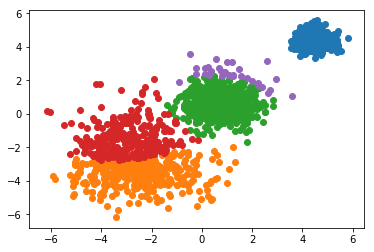

In [20]:
for i in range(K):
    if noise_data_num > 0:
        plt.scatter(x[np.where(max_label_arg_gibbs[:-noise_data_num] == i)[0],0], x[np.where(max_label_arg_gibbs[:-noise_data_num] == i)[0],1])
    else:
        plt.scatter(x[np.where(max_label_arg_gibbs == i)[0],0], x[np.where(max_label_arg_gibbs == i)[0],1])
    
plt.show()